In [47]:
import numpy as np
import time
import pyflann
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

## Carga de datos

In [2]:
oxford_features = np.load('features_oxford.npz')

db_features_oxford = oxford_features['bbdd']
querys_features_oxford = oxford_features['querys']

In [3]:
paris_features = np.load('features_paris2.npz')

db_features_paris = paris_features['bbdd']
querys_features_paris = paris_features['querys']

## Linear Scan

In [4]:
class Resultados:
    def __init__(self):
        self.segundos = 0
        self.precision = 0
        self.eficiencia = 0
        self.correctas = 0
        self.incorrectas = 0

def evaluar_busqueda(nns, dists, tiempo,nns_LS, dists_LS, time_LS):
    r = Resultados()
    for i in range(len(nns_LS)):
        if nns[i] == nns_LS[i] or dists[i] == dists_LS[i]:
            r.correctas +=1
        else:
            r.incorrectas +=1
    r.segundos = tiempo
    r.precision = 100*r.correctas/(r.correctas + r.incorrectas)
    r.eficiencia = 100* r.segundos/time_LS
    
    return r

### Oxford

In [5]:
flann_oxford = pyflann.FLANN()
flann_oxford.build_index(db_features_oxford , algorithm = "linear")
t0 =time.time()

nns_LS_ox, dists_LS_ox = flann_oxford.nn_index(querys_features_oxford, num_neighbors=1, cores=1)

time_LS_ox = time.time()-t0

print("Linear Scan = {:.1f} [s]".format(time_LS_ox))

Linear Scan = 0.2 [s]


In [6]:
r = evaluar_busqueda(nns_LS_ox, dists_LS_ox, time_LS_ox,nns_LS_ox, dists_LS_ox, time_LS_ox)
print("LinearScan")
print("Precision = {:.1f}%\teficiencia={:.1f}%".format(r.precision, r.eficiencia))
print("Correctas = {} Incorrectas = {} Segundos = {:.2f}".format(r.correctas, r.incorrectas, r.segundos))

LinearScan
Precision = 100.0%	eficiencia=100.0%
Correctas = 70 Incorrectas = 0 Segundos = 0.20


### Paris

In [7]:
flann_paris= pyflann.FLANN()
flann_paris.build_index(db_features_paris , algorithm = "linear")
t0 =time.time()

nns_LS_par, dists_LS_par = flann_paris.nn_index(querys_features_paris, num_neighbors=1, cores=1)

time_LS_par = time.time()-t0

print("Linear Scan = {:.1f} [s]".format(time_LS_par))

Linear Scan = 0.2 [s]


In [8]:
r = evaluar_busqueda(nns_LS_par, dists_LS_par, time_LS_par,nns_LS_par, dists_LS_par, time_LS_par)
print("LinearScan")
print("Precision = {:.1f}%\teficiencia={:.1f}%".format(r.precision, r.eficiencia))
print("Correctas = {} Incorrectas = {} Segundos = {:.2f}".format(r.correctas, r.incorrectas, r.segundos))

LinearScan
Precision = 100.0%	eficiencia=100.0%
Correctas = 70 Incorrectas = 0 Segundos = 0.24


## KD-Tree

In [21]:
def plot_precision_eficiencia(chek,precision,tiempos):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    ax1.plot(chek[1:], tiempos[1:], marker='o', linestyle='-', label='Tiempo')
    ax1.scatter(chek[0], tiempos[0], marker='*', color='black', s=100, label='Metodo Exacto')
    ax1.set_xlabel('Checks')
    ax1.set_ylabel('Tiempo [s]')
    ax1.legend()

    ax2.plot(chek[1:], precision[1:], marker='o', linestyle='-', color='C1', label='Precisión')
    ax2.scatter(chek[0], precision[0], marker='*', color='black', s=100, label='Metodo Exacto')
    ax2.set_xlabel('Checks')
    ax2.set_ylabel('Precisión [%]')
    ax2.legend()

    plt.tight_layout()

    plt.show()

### Oxford

In [22]:
flann_oxford.build_index(db_features_oxford , algorithm = "kdtree", trees=1)

check_list =[-1,1,10,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600]

time_list= []
precision_list =[]

for check in check_list:
    t0 =time.time()
    nns, dists = flann_oxford.nn_index(querys_features_oxford, num_neighbors=1, cores=1, checks=check)
    time_kd = time.time()-t0
    r = evaluar_busqueda(nns, dists, time_kd,nns_LS_ox, dists_LS_ox, time_LS_ox)

    time_list.append(r.segundos)
    precision_list.append(r.precision)

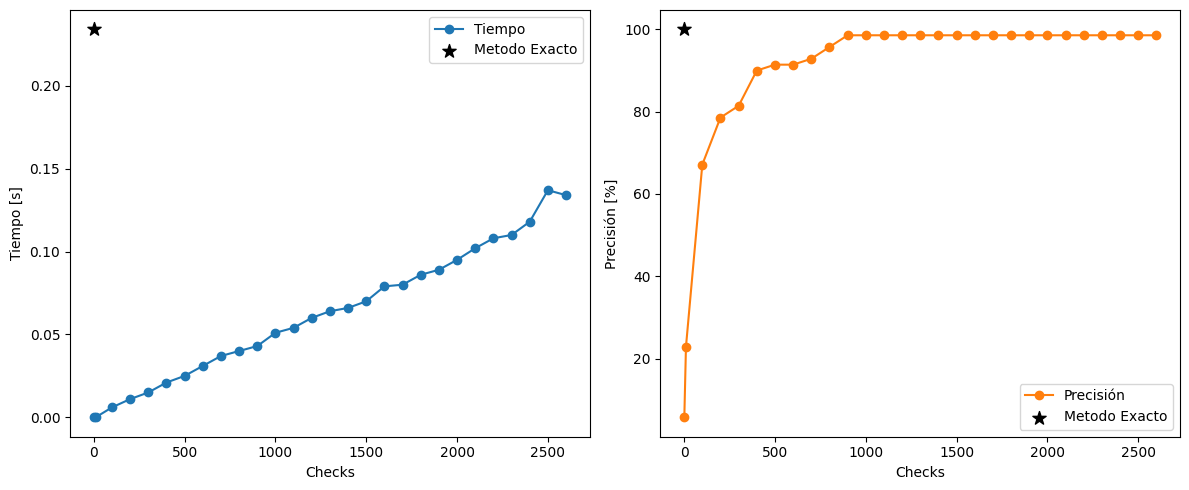

In [23]:
plot_precision_eficiencia(check_list,precision_list,time_list)

### Paris

In [24]:
flann_paris.build_index(db_features_paris , algorithm = "kdtree", trees=1)

check_list =[-1,1,10,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600]

time_list= []
precision_list =[]

for check in check_list:
    t0 =time.time()
    nns, dists = flann_paris.nn_index(querys_features_paris, num_neighbors=1, cores=1, checks=check)
    time_kd = time.time()-t0
    r = evaluar_busqueda(nns, dists, time_kd,nns_LS_par, dists_LS_par, time_LS_par)

    time_list.append(r.segundos)
    precision_list.append(r.precision)

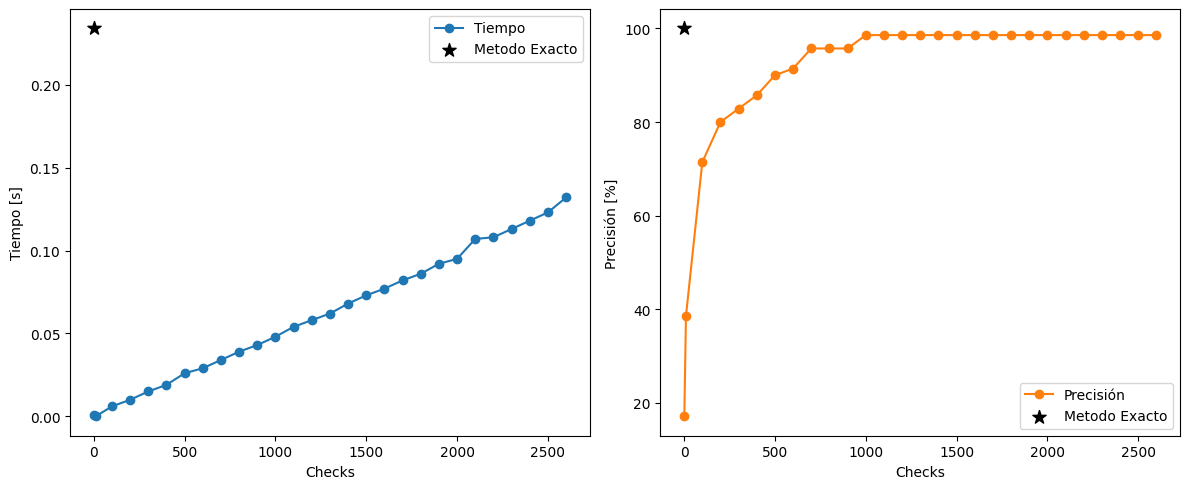

In [25]:
plot_precision_eficiencia(check_list,precision_list,time_list)

## PCA

In [123]:
def plot_precision_eficiencia_pca(componentes, precision, tiempos, varianza_acumulada):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(componentes, tiempos, label='Tiempo', linewidth=3)
    ax1.scatter(componentes[-1], tiempos[-1], marker='*', color='black', s=100, label='Metodo Exacto')
    ax1.set_xlabel('N° Componentes')
    ax1.set_ylabel('Tiempo [s]')
    ax1.legend()

    ax2.plot(componentes, precision, color='C1', label='Precisión', linewidth=3)
    ax2.scatter(componentes[-1], precision[-1], marker='*', color='black', s=100, label='Metodo Exacto')
    ax2.set_xlabel('N° Componentes')
    ax2.set_ylabel('Precisión [%]')
    ax2.legend()

    ax1_twin = ax1.twinx()
    ax1_twin.bar(componentes, varianza_acumulada, label='Varianza Acumulada', width=50, color='gray', alpha=0.2)
    ax1_twin.set_ylabel('Varianza Acumulada')

    ax2_twin = ax2.twinx()
    ax2_twin.bar(componentes, varianza_acumulada, label='Varianza Acumulada', width=50, color='gray', alpha=0.2)
    ax2_twin.set_ylabel('Varianza Acumulada')

    plt.tight_layout()

    plt.show()

### Oxford

In [124]:
componentes_list =[1,10,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2048]

time_list= []
precision_list =[]
varianza_list = []

flann_oxford = pyflann.FLANN()

for n_components in tqdm(componentes_list, desc="Procesando componentes"):

    pca = PCA(n_components=n_components)
    pca.fit(db_features_oxford)
    db_features_pca = pca.transform(db_features_oxford)
    querys_features_pca = pca.transform(querys_features_oxford)
    varianza_acumulada = pca.explained_variance_ratio_.sum()

    flann_oxford.build_index(db_features_pca , algorithm = "linear")

    t0 =time.time()
    nns, dists = flann_oxford.nn_index(querys_features_pca, num_neighbors=1, cores=1)
    time_pca = time.time()-t0
    r = evaluar_busqueda(nns, dists, time_pca, nns_LS_ox, dists_LS_ox, time_LS_ox)

    time_list.append(r.segundos)
    precision_list.append(r.precision)
    varianza_list.append(varianza_acumulada)

Procesando componentes: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


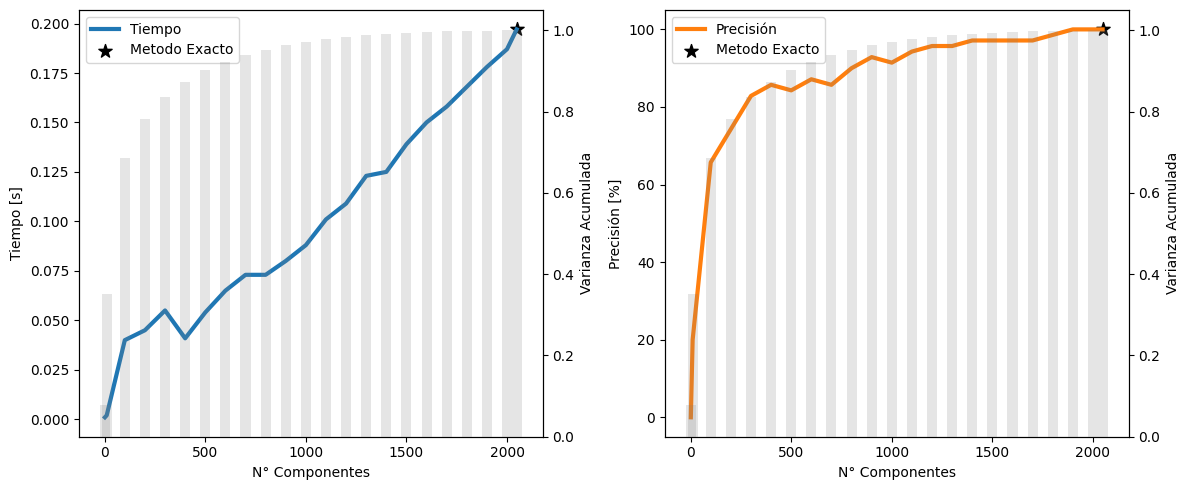

In [122]:
plot_precision_eficiencia_pca(componentes_list,precision_list,time_list,varianza_list)

### Paris

In [125]:
componentes_list =[1,10,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2048]

time_list= []
precision_list =[]
varianza_list = []

flann_paris = pyflann.FLANN()

for n_components in tqdm(componentes_list, desc="Procesando componentes"):

    pca = PCA(n_components=n_components)
    pca.fit(db_features_paris)
    db_features_pca = pca.transform(db_features_paris)
    querys_features_pca = pca.transform(querys_features_paris)
    varianza_acumulada = pca.explained_variance_ratio_.sum()

    flann_paris.build_index(db_features_pca , algorithm = "linear")

    t0 =time.time()
    nns, dists = flann_paris.nn_index(querys_features_pca, num_neighbors=1, cores=1)
    time_pca = time.time()-t0
    r = evaluar_busqueda(nns, dists, time_pca, nns_LS_par, dists_LS_par, time_LS_par)

    time_list.append(r.segundos)
    precision_list.append(r.precision)
    varianza_list.append(varianza_acumulada)

Procesando componentes: 100%|██████████| 23/23 [00:45<00:00,  1.96s/it]


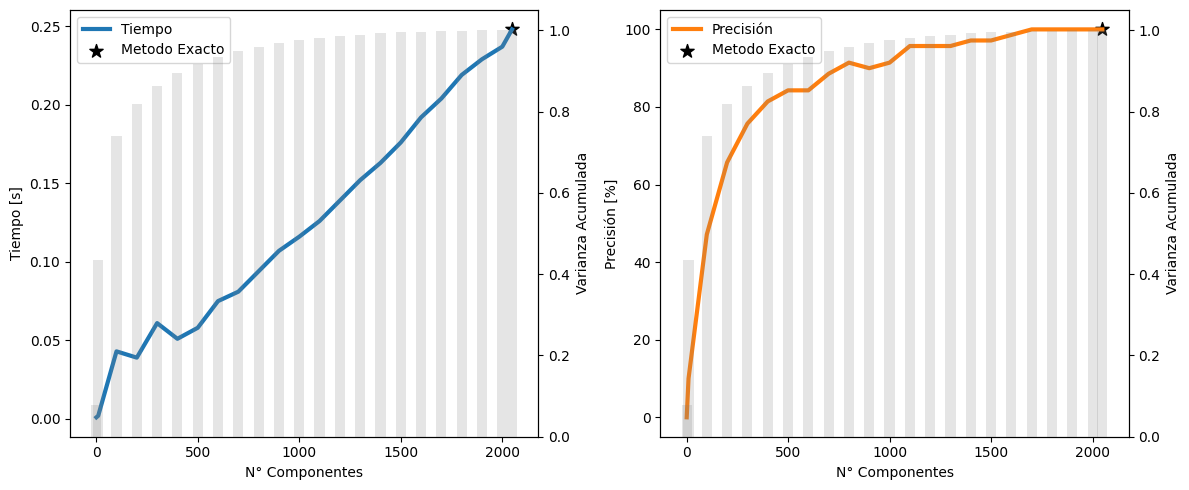

In [126]:
plot_precision_eficiencia_pca(componentes_list,precision_list,time_list,varianza_list)